In [1]:
import sys  
sys.path.insert(1, 'C:/Users/Kinga/Desktop/MAGISTERKA/code')

from clustering_script import *
from graph_generating_script import *

In [ ]:
# data - posdf
def choosing_number_of_clusters(data, max_clusters=20):
    best_score = -1
    best_num_clusters = 2  # Minimum number of clusters
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_num_clusters = n_clusters
    
    return best_num_clusters
    

In [49]:
import pandas as pd
import networkx as nx
from sklearn.cluster import Birch
import numpy as np
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import igraph as ig
import community
from graph_generating_script import *
from sklearn.model_selection import ParameterGrid
import networkx as nx


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_best_num_clusters(data, max_clusters=10):
    best_score = -1
    best_num_clusters = 2  # Minimum number of clusters
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_num_clusters = n_clusters
    
    return best_num_clusters


from sklearn.cluster import AgglomerativeClustering, OPTICS


# get results from one model on one graph on one of the layouts
# returns : scores - list with ARI

def get_clusters_from_positions(posdf, best_num, true_labels):
    #agglomerative clustering
    scores = []
    # for i in range(k):
    model = AgglomerativeClustering(affinity='euclidean', n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.labels_)
    # scores[0] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #DBscan
    model = OPTICS()
    model.fit(posdf)
    yhat= list(model.labels_)
    # scores[1] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    # kmeans
    model = KMeans(n_clusters=best_num, random_state=212)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[2] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #GMM
    from sklearn.mixture import GaussianMixture
    #modeling
    model = GaussianMixture(n_components=best_num, random_state=212).fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[3] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #Birch
    model = Birch(n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[4] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))


    return scores


def get_communities(G, true_labels):
    scores = []
    #separate tool to choose number of communities for girvan newman
    partition = community.best_partition(G)
    num_communities = len(set(partition.values()))
    print(f'community number {num_communities}')
    # print(f'Number for communities for Girvan Newman: {num_communities}')
    G1 = G.copy()
    
    while nx.number_connected_components(G1) < num_communities:
        edge_centrality = nx.edge_betweenness_centrality(G1)
        max_edge = max(edge_centrality, key=edge_centrality.get)
        G1.remove_edge(*max_edge)
    
    communities = list(nx.connected_components(G1))
    comms = []
    for com in communities:
        comms.append(list(com))
    list_comms = [None] * len(G.nodes)
    for i in range(len(comms)):
        com = comms[i]
        for node in com:
            list_comms[node] = i

    scores.append(adjusted_rand_score(true_labels, list_comms))
    # scores[5] += adjusted_rand_score(true_labels, list_comms)

    #Leiden
    # G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
    # partition = G_ig.community_leiden(objective_function="modularity")
    # list_comms = [None] * len(G.nodes)
    # for i, com in enumerate(partition):
    #     for node in com:
    #         list_comms[node] = i
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

    resolutions = np.linspace(0.1, 1.5, 10)  # Adjust the range as needed
    param_grid = {'resolution': resolutions}
    grid = ParameterGrid(param_grid)

    best_modularity = -np.inf
    best_partition = None
    for params in grid:
        partition = G_ig.community_leiden(objective_function="modularity", **params)
        modularity = G_ig.modularity(partition)
        if modularity > best_modularity:
            best_modularity = modularity
            best_partition = partition

    list_comms = [None] * len(G.nodes)
    for i, com in enumerate(best_partition):
        for node in com:
            list_comms[node] = i
    # scores[6] += adjusted_rand_score(true_labels, list_comms)
    scores.append(adjusted_rand_score(true_labels, list_comms))
    return scores

def add_scores(df, scores, layout_name='spring'):
    scores.insert(0, layout_name)
    data = df.to_dict('records')
    data.append(dict(zip(df.columns, scores)))
    df = pd.DataFrame(data)
    return df

# def scaling_igraph(layout):
#     coords = np.array(layout.coords)
#     min_coords = coords.min(axis=0)
#     max_coords = coords.max(axis=0)
#     scaled_coords = 2 * (coords - min_coords) / (max_coords - min_coords) - 1
#     posdf = pd.DataFrame(scaled_coords, columns=['X', 'Y'])
#     return posdf


# coducts ONE experiemnt for all (7) the layouts
# returns : df with ARI layouts and algoriths for ONE graph

def full_cluster_experiment(G, true_labels):
    # df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])
    df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch'])

    #for every layout
    #kamada kawai
    pos = nx.kamada_kawai_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print("kamada")
    print(best_num)
    # print(f'Best number of clusters detected : {best_num}')
    scores = get_clusters_from_positions(posdf, best_num, true_labels)
    df = add_scores(df, scores, 'kamada_kawai')

    #spring layout
    pos = nx.spring_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('spring')
    print(best_num)
    scores = get_clusters_from_positions(posdf, best_num, true_labels)
    df = add_scores(df, scores, 'spring')

    #algorithms from igraph
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

    #davidson harel
    layout = G_ig.layout('davidson_harel')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('davisdon harel')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'davidson_harel')

    #drl
    layout = G_ig.layout('drl')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('drl')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'drl')

    # fruchterman reingold
    layout = G_ig.layout('fruchterman_reingold')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('fruchterman')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'fruchterman_reingold')

    #graphopt
    layout = G_ig.layout('graphopt')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('graphopt')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'graphopt')

    #lgl
    layout = G_ig.layout('lgl')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('lgl')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'lgl')

    #mds
    layout = G_ig.layout('mds')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('mds')
    print(best_num)
    scores = get_clusters_from_positions(posdf, best_num, true_labels)
    df = add_scores(df, scores, 'mds')

    return df

# generates k graphs and conducts FULL experiments on them
# it sums up ARIs and divides by k (average)
# returns : df


def steady_full_experiment(sizes, inside_prob, outside_prob, k=5, i_want_boxplot=False):
    (G, true_labels)= generate_G(sizes, inside_prob, outside_prob)
    asor = nx.numeric_assortativity_coefficient(G, "community")
    df = full_cluster_experiment(G, true_labels)
    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: [x])
    #comms - list with two values
    comms = get_communities(G, true_labels)
    girvs = [comms[0]]
    leid = [comms[1]]
    #tu trzeba rozbic i osobno zrobic clustry, osobno community detection
    for i in range(1, k):
        print("DUPA")
        (G, true_labels)= generate_G(sizes, inside_prob, outside_prob)
        asor += nx.numeric_assortativity_coefficient(G, "community")
        tmp = full_cluster_experiment(G, true_labels)
        # df[df.columns[1:]] += tmp[tmp.columns[1:]]
        for column in df.columns[1:]:
            df[column] = df[column].combine(tmp[column], lambda x, y: x + [y])
            
        tmp = get_communities(G, true_labels)
        girvs.append(tmp[0])
        leid.append(tmp[1])
        # comms[0] += tmp[0]
        # comms[1] += tmp[1]


    # df[df.columns[1:]] /= k
    # df['Girvan-Newman'] = comms[0]/k
    df['Girvan-Newman'] = [girvs] * len(df)
    # df['Leiden'] = comms[1]/k
    df['Leiden'] = [leid] * len(df)

    print(f'Graphs assortavity coefficient : {asor/k}')
    if i_want_boxplot==False:
        df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: sum(x) / k)

    return df
    

In [48]:
steady_full_experiment([10, 20, 10], .8, .01, 5)

3
3
3
3
3
3
2
10
community number 3
DUPA
2
3
3
3
3
3
8
2
community number 3
DUPA
2
3
3
3
3
3
3
3
community number 3
DUPA
3
3
2
3
3
3
2
3
community number 3
DUPA
2
3
2
3
3
3
2
3
community number 3
Graphs assortavity coefficient : 0.9699172990174236


,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan-Newman,Leiden
0,kamada_kawai,0.745105,0.603094,0.761277,0.768465,0.555443,1.0,0.910857
1,spring,1.0,1.0,1.0,1.0,0.614815,1.0,0.910857
2,davidson_harel,0.733192,0.636459,0.717867,0.717867,0.733192,1.0,0.910857
3,drl,0.910857,0.748718,0.910857,0.910857,0.910857,1.0,0.910857
4,fruchterman_reingold,0.910857,0.910857,0.910857,0.910857,0.910857,1.0,0.910857
5,graphopt,0.910857,0.873393,0.910857,0.910857,0.910857,1.0,0.910857
6,lgl,0.129287,0.418428,0.121536,0.175702,0.129287,1.0,0.910857
7,mds,0.759238,0.728679,0.813825,0.777459,0.85272,1.0,0.910857


In [31]:
steady_full_experiment([10, 20, 10], .8, .01, 5)

Graphs assortavity coefficient : 0.958460767131948


,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan-Newman,Leiden
0,kamada_kawai,0.886370,0.754916,0.911220,0.929952,0.806637,1.0,0.879657
1,spring,1.000000,1.000000,1.000000,1.000000,0.745982,1.0,0.879657
2,davidson_harel,0.733978,0.811449,0.706498,0.673681,0.733978,1.0,0.879657
3,drl,0.879657,0.709509,0.879657,0.879657,0.879657,1.0,0.879657
4,fruchterman_reingold,0.879657,0.741324,0.879657,0.879657,0.879657,1.0,0.879657
5,graphopt,0.879657,0.796274,0.879657,0.879657,0.879657,1.0,0.879657
6,lgl,0.236174,0.410186,0.242340,0.219022,0.236174,1.0,0.879657
7,mds,0.650733,0.606515,0.705751,0.705751,0.753496,1.0,0.879657


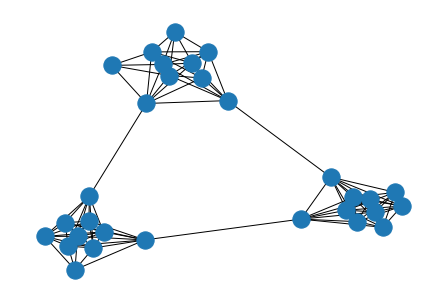

In [3]:
(G, true_labels) = generate_G([10,10,10], .8, .01)
nx.draw(G)


In [6]:
nx.numeric_assortativity_coefficient(G, "community")

0.957137239480928

0.8581232045962336


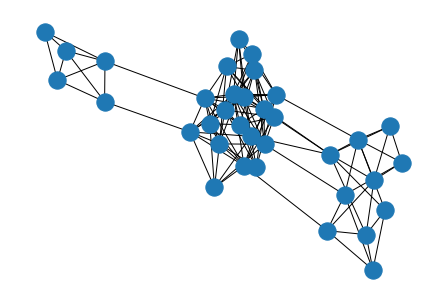

In [6]:
(G, true_labels) = generate_G([20, 10, 5], .5, .02)
print(nx.numeric_assortativity_coefficient(G, "community"))
nx.draw(G)


In [7]:
# (G, true_labels) = generate_G([10, 20, 10, 5], .5, .1)

# nx.numeric_assortativity_coefficient(G, "community")

0.23049794573886268

In [4]:
steady_full_experiment([10, 20, 10], .5, .05, 2)

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

In [17]:
steady_full_experiment([10, 20, 10, 5], .5, .1, 5)

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.488317,0.075913,0.615562,0.493540,0.417849,0.128022,0.081946
1,spring,0.618064,0.134104,0.567746,0.595017,0.292294,0.149314,0.067360
2,davidson_harel,0.032229,-0.000483,0.036389,0.020191,0.036277,0.198364,0.055562
3,drl,-0.017668,-0.013003,0.011505,0.008943,0.029781,0.149314,0.073210
4,fruchterman_reingold,0.056950,-0.008566,0.072012,0.054018,0.084206,0.138458,0.070070
5,graphopt,0.043254,-0.005621,0.069452,0.050784,0.043254,0.132840,0.062869
6,lgl,-0.021178,-0.009076,-0.021178,-0.020768,-0.021178,0.125777,0.060686
7,mds,0.060972,0.007314,0.083794,0.079855,0.078334,0.149314,0.061835


In [10]:
steady_full_experiment([10, 20, 10, 5], .5, .1, 5)

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.565085,0.083406,0.705555,0.719825,0.409568,0.173092,0.116488
1,spring,0.597514,0.241185,0.690052,0.632466,0.228530,0.092829,0.135165
2,davidson_harel,0.027833,0.023194,0.035286,0.023552,0.027833,0.092263,0.120174
3,drl,0.014287,0.037210,0.010380,0.001385,0.024654,0.095305,0.115066
4,fruchterman_reingold,0.101366,0.016177,0.097321,0.110208,0.109980,0.089348,0.107308
5,graphopt,0.092796,0.025202,0.080325,0.070435,0.092796,0.092263,0.115066
6,lgl,-0.003837,0.047701,-0.003837,-0.003837,-0.003837,0.170050,0.135165
7,mds,0.093982,0.014848,0.089432,0.109234,0.083536,0.094740,0.131480


# Testing number of clusters

In [52]:
steady_full_experiment([10, 5, 10, 5, 10], .6, .05, 3)

kamada
3
spring
2
davisdon harel
3
drl
2
fruchterman
3
graphopt
4
lgl
4
mds
3
community number 4
DUPA
kamada
4
spring
2
davisdon harel
2
drl
2
fruchterman
2
graphopt
2
lgl
2
mds
3
community number 4
DUPA
kamada
3
spring
3
davisdon harel
3
drl
3
fruchterman
3
graphopt
5
lgl
2
mds
3
community number 5
Graphs assortavity coefficient : 0.6613781005101759


,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan-Newman,Leiden
0,kamada_kawai,0.444779,0.039803,0.487107,0.477248,0.433762,0.699465,0.237521
1,spring,0.377436,0.291447,0.420322,0.443124,0.307301,0.699465,0.237521
2,davidson_harel,0.085265,0.11789,0.162376,0.094421,0.085265,0.699465,0.237521
3,drl,0.036064,0.020963,0.067842,0.055836,0.060482,0.699465,0.237521
4,fruchterman_reingold,0.139913,0.011161,0.168956,0.131983,0.160352,0.699465,0.237521
5,graphopt,0.151424,0.038811,0.156033,0.191296,0.151424,0.699465,0.237521
6,lgl,0.012042,0.060541,0.012042,0.012042,0.012042,0.699465,0.237521
7,mds,0.14357,0.171366,0.223865,0.228314,0.164859,0.699465,0.237521
